# Process micro-benchmark outputs

This notebook extracts Loop time values from the organized files in `apps/<benchmark>/`.
By default it uses `dvfs` outputs; change `group` to `energy` to switch.


In [105]:
from pathlib import Path
import re

group = 'energy'  # change to 'energy' if needed
baseline_freq = '2.25GHz'
selected_freqs = ['1.5GHz', '1.8GHz', '2.25GHz']  # e.g., ['0.8GHz', '1.0GHz']; leave empty to use all

loop_time_re = re.compile(r'Loop time:\s*([0-9.]+)\s*seconds')
freq_re = re.compile(rf'_(?:{group})_([0-9.]+GHz)\.out$')

def find_apps_dir(start: Path) -> Path:
    current = start.resolve()
    for _ in range(6):
        candidate = current / 'apps'
        if candidate.is_dir():
            return candidate
        if current.parent == current:
            break
        current = current.parent
    raise FileNotFoundError('No apps directory found. Run from repo root or set apps_dir manually.')

apps_dir = find_apps_dir(Path.cwd())

def parse_loop_time(path: Path):
    for line in path.read_text().splitlines():
        match = loop_time_re.search(line)
        if match:
            return float(match.group(1))
    return None

def extract_freq(path: Path):
    match = freq_re.search(path.name)
    if not match:
        return None
    return match.group(1)

def freq_value(freq: str):
    return float(freq.replace('GHz', ''))

raw_results = {}
perf_results = {}
missing_baseline = []
for app_dir in sorted(apps_dir.iterdir()):
    if not app_dir.is_dir():
        continue
    entries = []
    for out_file in sorted(app_dir.glob(f'*_{group}_*.out')):
        freq = extract_freq(out_file)
        if not freq:
            continue
        if selected_freqs and freq not in selected_freqs:
            continue
        loop_time = parse_loop_time(out_file)
        if loop_time is None:
            continue
        entries.append((freq, loop_time))
    if not entries:
        continue
    entries.sort(key=lambda item: freq_value(item[0]))
    raw_results[app_dir.name] = entries
    base = None
    for freq, time in entries:
        if freq == baseline_freq:
            base = time
            break
    if base is None:
        missing_baseline.append(app_dir.name)
        continue
    perf_entries = [(freq, base / time) for freq, time in entries]
    perf_results[app_dir.name] = perf_entries

perf_results


{'atomic_fight': [('1.5GHz', 0.6819195781500166),
  ('1.8GHz', 0.8226989317695675),
  ('2.25GHz', 1.0)],
 'branch_mispredict': [('1.5GHz', 0.6652765608660841),
  ('1.8GHz', 0.7990123229952173),
  ('2.25GHz', 1.0)],
 'dgemm': [('1.5GHz', 0.6798364239590268),
  ('1.8GHz', 0.8086762902677435),
  ('2.25GHz', 1.0)],
 'fft_mix': [('1.5GHz', 0.6673917975679626),
  ('1.8GHz', 0.8007076077849725),
  ('2.25GHz', 1.0)],
 'icache_thrash': [('1.5GHz', 0.6653273071404163),
  ('1.8GHz', 0.798944055617834),
  ('2.25GHz', 1.0)],
 'io_write': [('1.5GHz', 0.7382037850858447),
  ('1.8GHz', 0.8879224775367938),
  ('2.25GHz', 1.0)],
 'l3_stencil': [('1.5GHz', 0.8216460296343023),
  ('1.8GHz', 0.8925613494797774),
  ('2.25GHz', 1.0)],
 'mpi_bandwidth': [('1.5GHz', 1.0002738915165272),
  ('1.8GHz', 0.9928800928930507),
  ('2.25GHz', 1.0)],
 'mpi_barrier': [('1.5GHz', 0.8176480742051759),
  ('1.8GHz', 0.8862370778853053),
  ('2.25GHz', 1.0)],
 'pointer_chase': [('1.5GHz', 0.8881582743615286),
  ('1.8GHz', 0.97

In [106]:
# Energy profile helpers (from process_apps_energy.ipynb)
from pathlib import Path
from typing import Dict, List, Sequence
import pandas as pd

SUM_FIELDS = {
    "Energy [J]",
    "Power [W]",
    "Energy PP0 [J]",
    "Power PP0 [W]",
    "Energy DRAM [J]",
    "Power DRAM [W]",
    "Energy PLATFORM [J]",
    "Power PLATFORM [W]",
    "Memory read bandwidth [MBytes/s]",
    "Memory read data volume [GBytes]",
    "Memory write bandwidth [MBytes/s]",
    "Memory write data volume [GBytes]",
    "Memory bandwidth [MBytes/s]",
    "Memory data volume [GBytes]",
    "L3 request rate",
    "L3 miss rate",
    "L3 miss ratio",
    "Energy Core [J]",
    "Power Core [W]",
    "Energy L3 [J]",
    "Power L3 [W]",
}

def find_apps_dir(start: Path) -> Path:
    current = start.resolve()
    for _ in range(6):
        candidate = current / 'apps'
        if candidate.is_dir():
            return candidate
        if current.parent == current:
            break
        current = current.parent
    raise FileNotFoundError('No apps directory found. Run from repo root or set apps_dir manually.')

def parse_headers(stdout_path: Path) -> List[Sequence[str]]:
    headers: List[Sequence[str]] = []
    with stdout_path.open() as handle:
        for line in handle:
            if line.startswith('# GID|'):
                parts = line.lstrip('#').strip().split('|')
                fields = parts[3:]
                if fields:
                    headers.append(fields)
    if not headers:
        raise RuntimeError(f'No LIKWID headers found in {stdout_path}')
    return headers

def aggregate_metric(values: Sequence[float], field: str) -> float:
    if not values:
        raise KeyError(f'Missing values for field {field}')
    if field in SUM_FIELDS:
        return float(sum(values))
    return float(sum(values) / len(values))

def load_energy_profile(app: str, freq: str, *, apps_dir: Path | None = None, group: str = 'energy') -> pd.DataFrame:
    if apps_dir is None:
        apps_dir = find_apps_dir(Path.cwd())

    out_path = apps_dir / app / f'{app}_{group}_{freq}.out'
    prof_path = apps_dir / app / f'{app}_{group}_{freq}.prof'
    if not out_path.exists():
        raise FileNotFoundError(f'Missing header file: {out_path}')
    if not prof_path.exists():
        raise FileNotFoundError(f'Missing profile file: {prof_path}')

    headers = parse_headers(out_path)
    if len(headers) != 1:
        print(f'Warning: expected 1 header set, found {len(headers)} in {out_path.name}')
    header = headers[0]
    global_field = header[0]
    metric_fields = header[1:]

    rows: List[Dict[str, float]] = []
    in_loop = False
    saw_start = False
    saw_end = False

    with prof_path.open() as handle:
        for raw_line in handle:
            line = raw_line.strip()
            if not line:
                continue
            if line.startswith('LOOP_START_REL'):
                in_loop = True
                saw_start = True
                continue
            if line.startswith('LOOP_END_REL'):
                in_loop = False
                saw_end = True
                break
            if not in_loop:
                continue
            if line.startswith('#'):
                continue
            parts = line.split(',')
            if len(parts) < 4:
                continue
            gid = int(parts[0])
            metrics_count = int(parts[1])
            cpu_count = int(parts[2])
            values = [float(val) for val in parts[3:]]

            if metrics_count != len(metric_fields):
                raise ValueError(
                    f'Header mismatch: expected {len(metric_fields)} metrics, got {metrics_count} in {prof_path.name}'
                )

            expected_values = 1 + metrics_count * cpu_count
            if len(values) != expected_values:
                raise ValueError(
                    f'Expected {expected_values} numeric entries, got {len(values)} in {prof_path.name}'
                )

            global_value = values[0]
            metric_values = values[1:]

            extracted: Dict[str, float] = {global_field: global_value}
            for idx, field in enumerate(metric_fields):
                start = idx * cpu_count
                end = start + cpu_count
                segment = metric_values[start:end]
                if not segment:
                    continue
                extracted[field] = aggregate_metric(segment, field)

            extracted['gid'] = gid
            rows.append(extracted)

    if not saw_start:
        raise RuntimeError(f'LOOP_START_REL marker not found in {prof_path.name}')
    if not saw_end:
        raise RuntimeError(f'LOOP_END_REL marker not found in {prof_path.name}')
    if not rows:
        raise RuntimeError(f'No samples found between loop markers in {prof_path.name}')

    return pd.DataFrame(rows)

def clean_abnormal(df: pd.DataFrame, *, z_thresh: float = 8.0, cols: list[str] | None = None) -> pd.DataFrame:
    numeric_cols = [c for c in df.columns if c != "gid"]
    if cols is None:
        cols = numeric_cols
    cleaned = df.copy()
    for col in cols:
        if col not in cleaned.columns:
            continue
        series = cleaned[col]
        median = series.median()
        mad = (series - median).abs().median()
        if mad == 0 or series.isna().all():
            continue
        robust_z = (series - median).abs() / (1.4826 * mad)
        mask = robust_z > z_thresh
        if mask.any():
            cleaned.loc[mask, col] = pd.NA
            cleaned[col] = cleaned[col].ffill().bfill()
    return cleaned

In [107]:
# Total energy per benchmark/frequency (within LOOP_START_REL/LOOP_END_REL)
from pathlib import Path
import re

energy_group = 'energy'
power_field = 'Power L3 [W]'
energy_freq_re = re.compile(rf'_(?:{energy_group})_([0-9.]+GHz)\.out$')

apps_dir = find_apps_dir(Path.cwd())

def extract_energy_freq(path: Path):
    match = energy_freq_re.search(path.name)
    if not match:
        return None
    return match.group(1)

energy_raw = {}
energy_results = {}
missing_energy_baseline = []
for app_dir in sorted(apps_dir.iterdir()):
    if not app_dir.is_dir():
        continue
    entries = []
    for out_file in sorted(app_dir.glob(f'*_{energy_group}_*.out')):
        freq = extract_energy_freq(out_file)
        if not freq:
            continue
        if selected_freqs and freq not in selected_freqs:
            continue
        df = load_energy_profile(app_dir.name, freq, apps_dir=apps_dir, group=energy_group)
        df = clean_abnormal(df)
        if power_field not in df.columns:
            raise KeyError(f'Missing {power_field} in {app_dir.name} {freq}')
        time_field = df.columns[0]
        if time_field == 'gid':
            raise KeyError('Time field not found in energy profile data')
        times = df[time_field].to_numpy()
        powers = df[power_field].to_numpy()
        if len(times) < 2:
            raise RuntimeError(f'Not enough samples to integrate power for {app_dir.name} {freq}')
        deltas = times[1:] - times[:-1]
        total_energy = float((powers[:-1] * deltas).sum())
        entries.append((freq, total_energy))
    if not entries:
        continue
    entries.sort(key=lambda item: freq_value(item[0]))
    energy_raw[app_dir.name] = entries
    base = None
    for freq, energy in entries:
        if freq == baseline_freq:
            base = energy
            break
    if base is None:
        missing_energy_baseline.append(app_dir.name)
        continue
    rel_entries = [(freq, energy / base) for freq, energy in entries]
    energy_results[app_dir.name] = rel_entries

energy_results


{'atomic_fight': [('1.5GHz', 1.2938724877379695),
  ('1.8GHz', 1.1340268393408206),
  ('2.25GHz', 1.0)],
 'branch_mispredict': [('1.5GHz', 1.124105723347256),
  ('1.8GHz', 1.0674887362157197),
  ('2.25GHz', 1.0)],
 'dgemm': [('1.5GHz', 1.0055983300666511),
  ('1.8GHz', 1.0067179895516394),
  ('2.25GHz', 1.0)],
 'fft_mix': [('1.5GHz', 1.025030134222936),
  ('1.8GHz', 1.0066246181341612),
  ('2.25GHz', 1.0)],
 'icache_thrash': [('1.5GHz', 1.0127212314005356),
  ('1.8GHz', 0.964004383025306),
  ('2.25GHz', 1.0)],
 'io_write': [('1.5GHz', 1.2457037051569728),
  ('1.8GHz', 1.061954713994376),
  ('2.25GHz', 1.0)],
 'l3_stencil': [('1.5GHz', 1.040501420834286),
  ('1.8GHz', 1.0234976743658577),
  ('2.25GHz', 1.0)],
 'mpi_bandwidth': [('1.5GHz', 0.6839982376169147),
  ('1.8GHz', 0.8172215056673534),
  ('2.25GHz', 1.0)],
 'mpi_barrier': [('1.5GHz', 0.8675612175891783),
  ('1.8GHz', 0.9370122178351493),
  ('2.25GHz', 1.0)],
 'pointer_chase': [('1.5GHz', 0.9937342539482815),
  ('1.8GHz', 0.963465

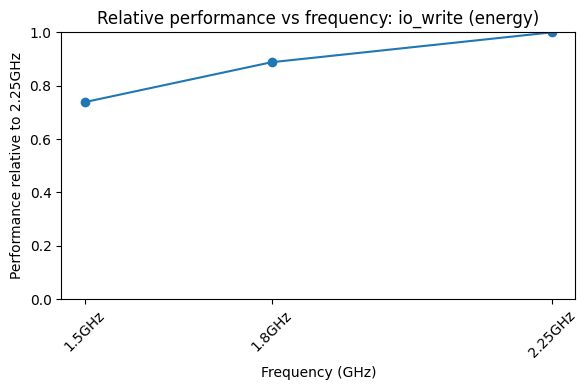

In [108]:
# Example: plot a single benchmark
import matplotlib.pyplot as plt

# app = next(iter(perf_results)) if perf_results else None
app = 'io_write'  # specify benchmark name here
if app:
    freqs = [float(f.replace('GHz', '')) for f, _ in perf_results[app]]
    labels = [f for f, _ in perf_results[app]]
    perf = [p for _, p in perf_results[app]]

    plt.figure(figsize=(6, 4))
    plt.plot(freqs, perf, marker='o')
    plt.title(f'Relative performance vs frequency: {app} ({group})')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel(f'Performance relative to {baseline_freq}')
    plt.xticks(freqs, labels, rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


In [109]:
perf

[0.7382037850858447, 0.8879224775367938, 1.0]

In [110]:
# Benchmark groups (edit these lists to control selection)
run_fast = [
    'dgemm',
    'branch_mispredict',
    'icache_thrash',
    # 'tree_walk',
    'fft_mix',
]

feed_me = [
    'l3_stencil',
    'stream',
    'spmv',
]

system_group = [
    'pointer_chase',
    'atomic_fight',
    'mpi_bandwidth',
]

sleep_group = [
    'mpi_barrier',
    'io_write',
]

# selected = []  # e.g., ['atomic_fight', 'dgemm']; leave empty to plot all
selected = run_fast + feed_me + system_group + sleep_group

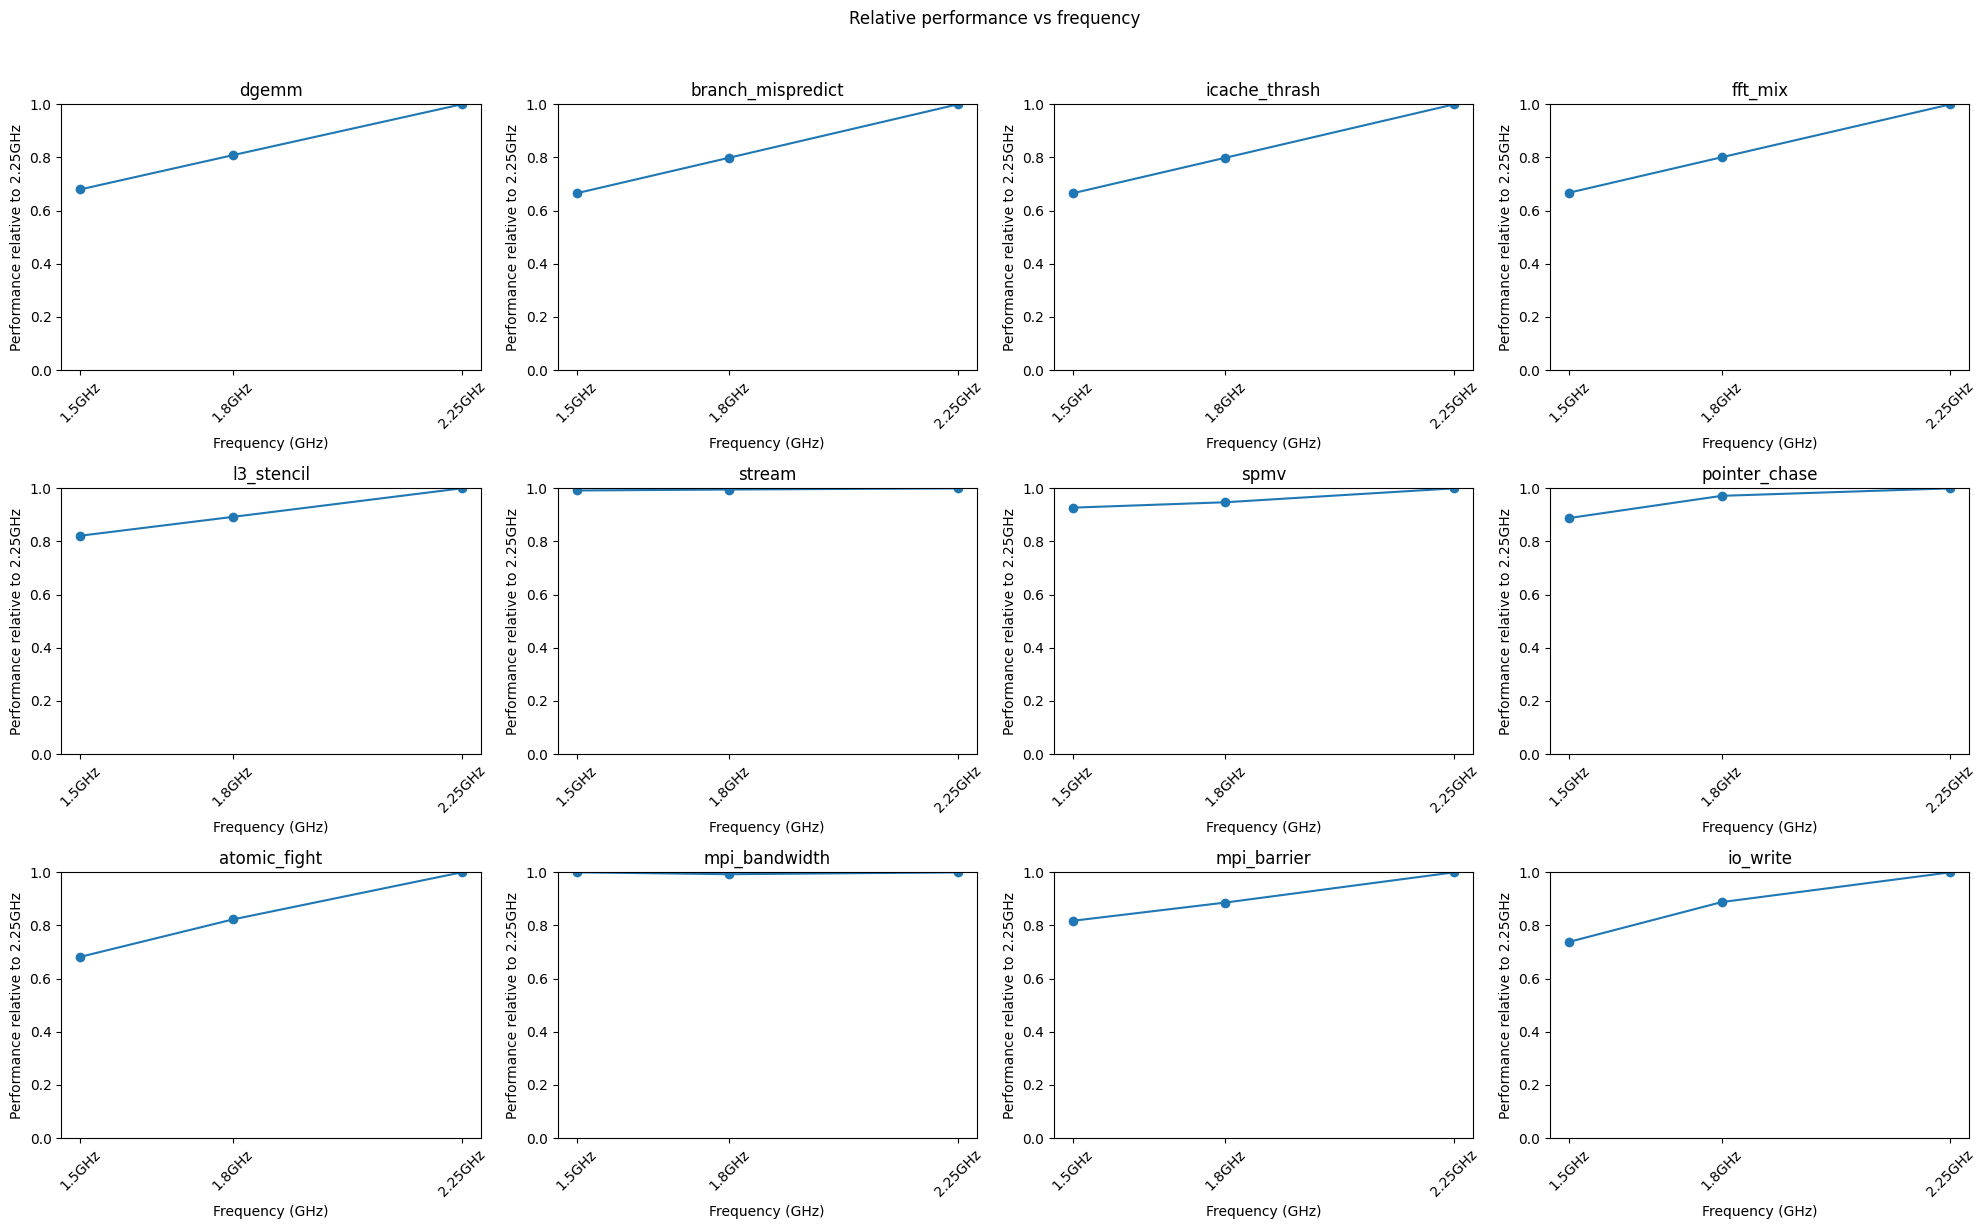

In [111]:
import math

apps = list(perf_results.keys())
if selected:
    apps = [app for app in selected if app in perf_results]

if apps:
    cols = 4
    rows = math.ceil(len(apps) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes if isinstance(axes, (list, tuple)) else axes.flatten()

    for ax, app in zip(axes, apps):
        freqs = [float(f.replace('GHz', '')) for f, _ in perf_results[app]]
        labels = [f for f, _ in perf_results[app]]
        perf = [p for _, p in perf_results[app]]
        ax.plot(freqs, perf, marker='o')
        ax.set_title(app)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel(f'Performance relative to {baseline_freq}')
        ax.set_xticks(freqs, labels, rotation=45)
        ax.set_ylim(0, 1)

    for ax in axes[len(apps):]:
        ax.axis('off')

    fig.suptitle('Relative performance vs frequency', y=1.02)
    fig.tight_layout()
    plt.show()


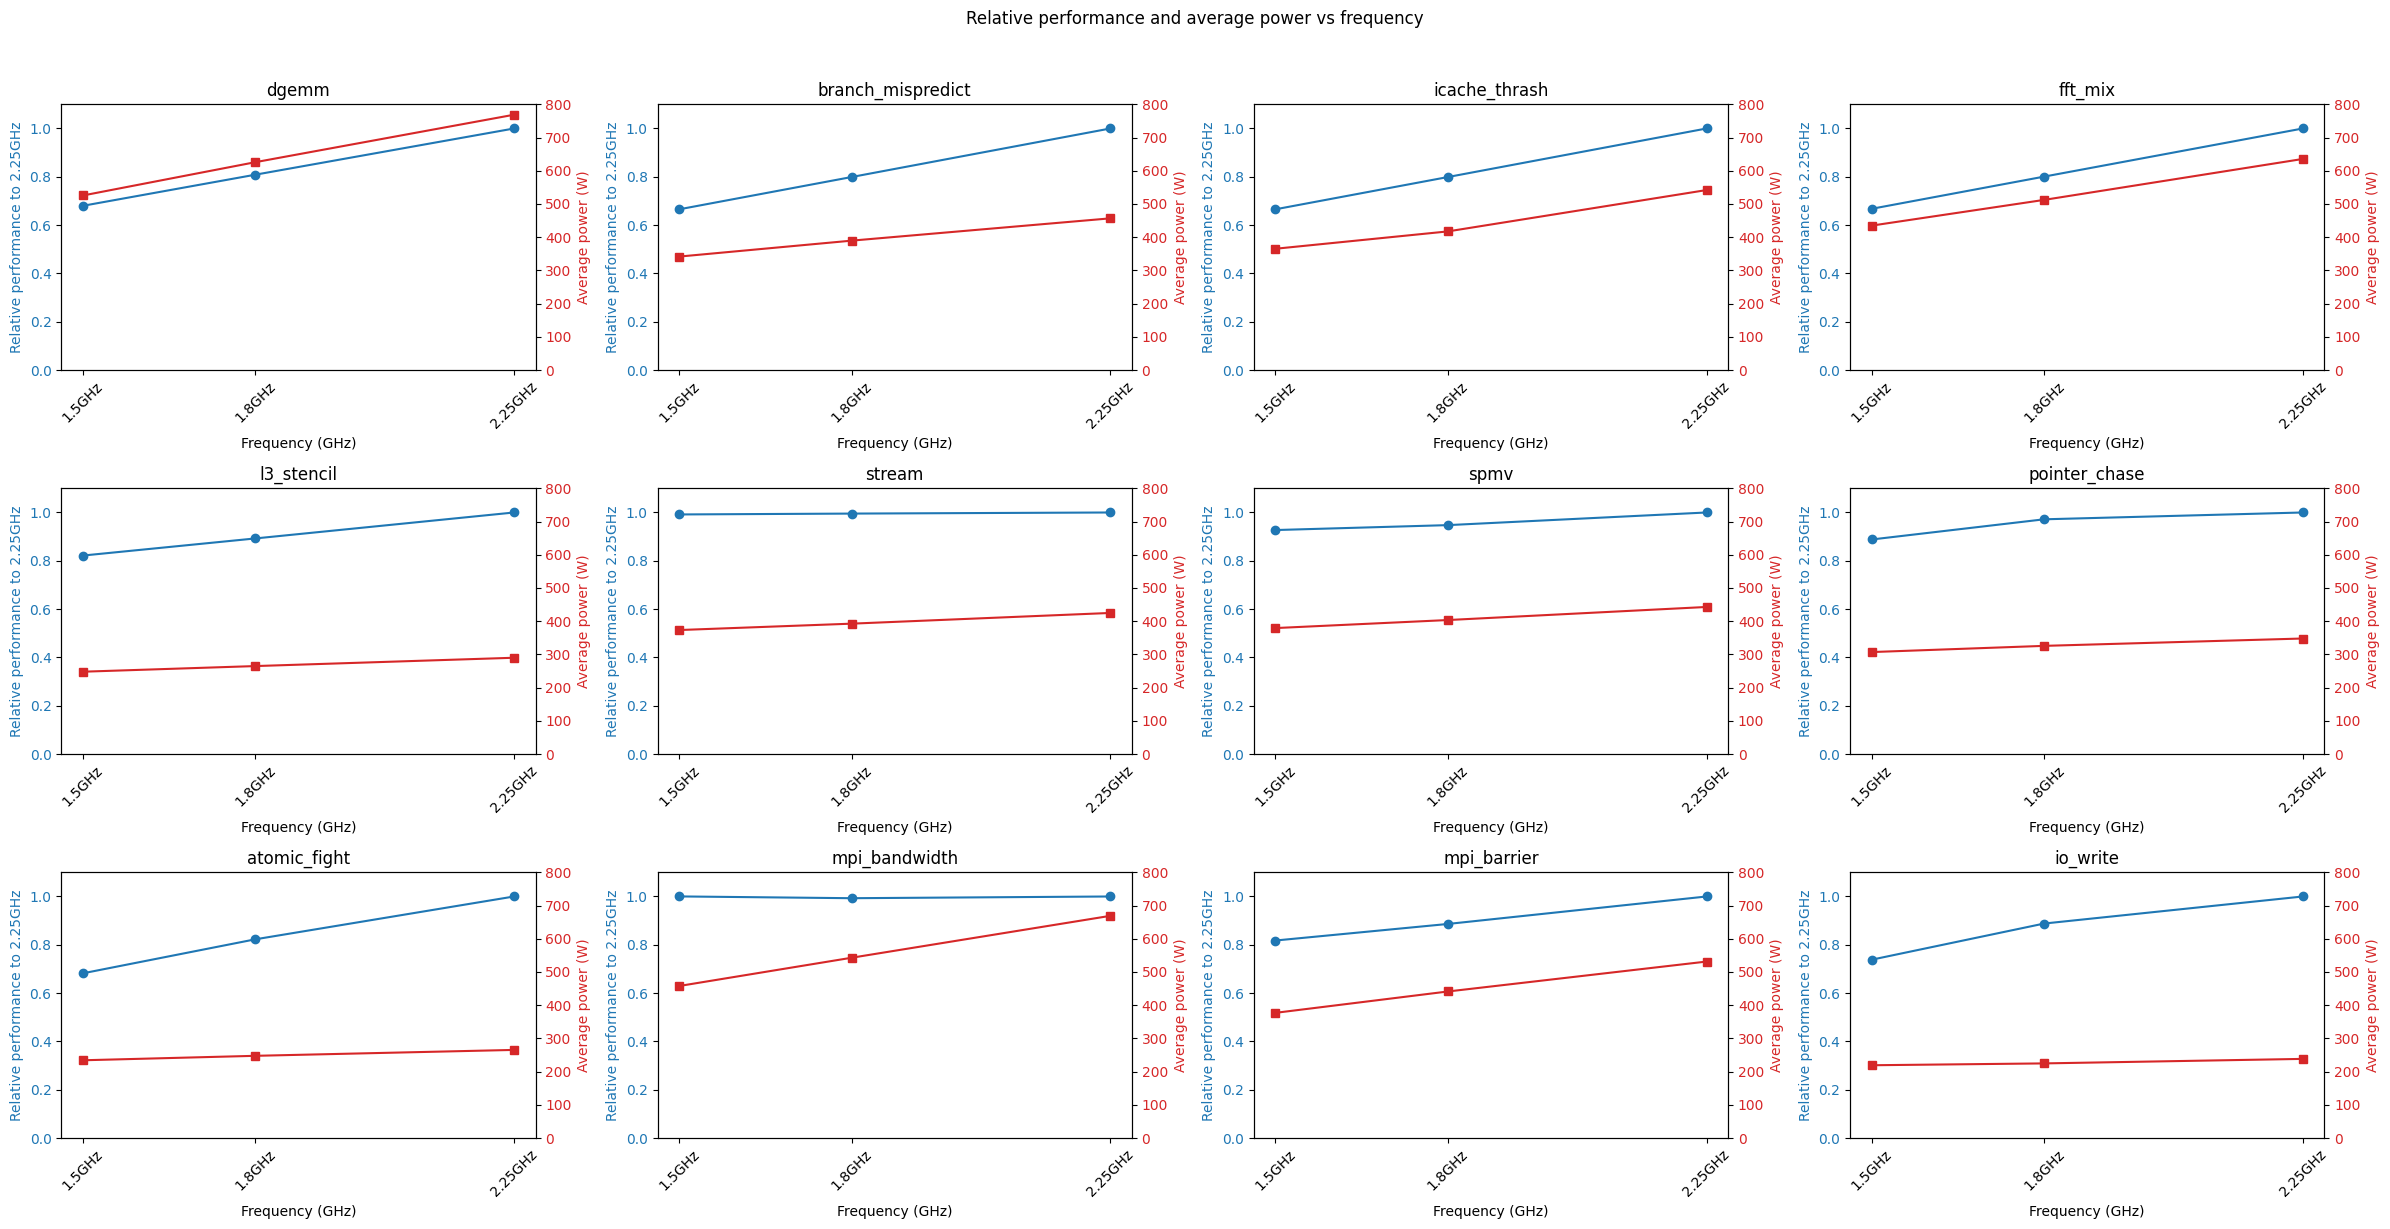

In [112]:
# Plot relative performance (left axis) and average power (right axis)
import math
import matplotlib.pyplot as plt

apps = sorted(set(perf_results.keys()) & set(raw_results.keys()))
if 'selected' in globals() and selected:
    apps = [app for app in selected if app in perf_results and app in raw_results]

def build_lookup(pairs):
    return {freq: value for freq, value in pairs}

if apps:
    cols = 4
    rows = math.ceil(len(apps) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes if isinstance(axes, (list, tuple)) else axes.flatten()

    for ax, app in zip(axes, apps):
        perf_map = build_lookup(perf_results[app])
        raw_time_map = build_lookup(raw_results[app])
        perf_freqs = sorted(perf_map.keys(), key=freq_value)
        if not perf_freqs:
            ax.axis('off')
            continue
        x_perf = [float(f.replace('GHz', '')) for f in perf_freqs]
        ax.plot(x_perf, [perf_map[f] for f in perf_freqs], marker='o', color='tab:blue')
        ax.set_title(app)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel(f'Relative performance to {baseline_freq}', color='tab:blue')
        ax.set_xticks(x_perf, perf_freqs, rotation=45)
        ax.set_ylim(0, 1.1)
        ax.tick_params(axis='y', labelcolor='tab:blue')

        if app in energy_raw:
            energy_map = build_lookup(energy_raw[app])
            power_freqs = [f for f in perf_freqs if f in energy_map and f in raw_time_map]
            if power_freqs:
                x_power = [float(f.replace('GHz', '')) for f in power_freqs]
                avg_power = [energy_map[f] / raw_time_map[f] for f in power_freqs]
                ax2 = ax.twinx()
                ax2.plot(x_power, avg_power, marker='s', color='tab:red')
                ax2.set_ylabel('Average power (W)', color='tab:red')
                ax2.set_ylim(0, 800)
                ax2.tick_params(axis='y', labelcolor='tab:red')

    for ax in axes[len(apps):]:
        ax.axis('off')

    fig.suptitle('Relative performance and average power vs frequency', y=1.02)
    fig.tight_layout()
    plt.show()


In [113]:
# Find best frequency for lowest energy and lowest EDP
import pandas as pd

def build_lookup(pairs):
    return {freq: value for freq, value in pairs}

apps = sorted(set(raw_results.keys()) & set(energy_raw.keys()))
if 'selected' in globals() and selected:
    apps = [app for app in selected if app in raw_results and app in energy_raw]

rows = []
for app in apps:
    time_map = build_lookup(raw_results[app])
    energy_map = build_lookup(energy_raw[app])
    freqs = sorted(set(time_map) & set(energy_map), key=freq_value)
    if not freqs:
        continue
    energy_vals = {f: energy_map[f] for f in freqs}
    edp_vals = {f: energy_map[f] * time_map[f] for f in freqs}
    best_energy_freq = min(energy_vals, key=energy_vals.get)
    best_edp_freq = min(edp_vals, key=edp_vals.get)
    rows.append({
        'app': app,
        'best_energy_freq': best_energy_freq,
        'energy_j': energy_vals[best_energy_freq],
        'runtime_s': time_map[best_energy_freq],
        'best_edp_freq': best_edp_freq,
        'edp_j_s': edp_vals[best_edp_freq],
    })

best_freqs = pd.DataFrame(rows).sort_values('app')
best_freqs


,app,best_energy_freq,energy_j,runtime_s,best_edp_freq,edp_j_s
8,atomic_fight,2.25GHz,29093.410043,109.666833,2.25GHz,3.190582e+06
1,branch_mispredict,2.25GHz,26040.564838,57.019274,2.25GHz,1.484814e+06
0,dgemm,2.25GHz,100084.243108,130.200263,2.25GHz,1.303099e+07
3,fft_mix,2.25GHz,42232.219027,66.453474,2.25GHz,2.806478e+06
2,icache_thrash,1.8GHz,3820.126720,9.153323,2.25GHz,2.897970e+04
11,io_write,2.25GHz,186062.876450,780.940574,2.25GHz,1.453040e+08
4,l3_stencil,2.25GHz,154940.267938,534.503985,2.25GHz,8.281619e+07
9,mpi_bandwidth,1.5GHz,244809.131073,534.857749,1.5GHz,1.309381e+08
10,mpi_barrier,1.5GHz,154538.979245,410.039969,2.25GHz,5.972147e+07
7,pointer_chase,1.8GHz,32552.153307,99.962362,1.8GHz,3.253990e+06


In [114]:
# Build frequency label dictionaries from best_freqs
FREQ_LABELS = {
    'HighFreq': '2.25GHz',
    'MedFreq': '1.8GHz',
    'LowFreq': '1.5GHz',
}

LABELS = {label: set() for label in FREQ_LABELS}

for _, row in best_freqs.iterrows():
    freq = row['best_energy_freq']
    label = next((k for k, v in FREQ_LABELS.items() if v == freq), None)
    if label:
        LABELS[label].add(row['app'])

LABELS


{'HighFreq': {'atomic_fight',
  'branch_mispredict',
  'dgemm',
  'fft_mix',
  'io_write',
  'l3_stencil'},
 'MedFreq': {'icache_thrash', 'pointer_chase'},
 'LowFreq': {'mpi_bandwidth', 'mpi_barrier', 'spmv', 'stream'}}

In [115]:
# Build frequency label dictionaries from best_edp_freq
FREQ_LABELS = {
    'HighFreq': '2.25GHz',
    'MedFreq': '1.8GHz',
    'LowFreq': '1.5GHz',
}

EDP_LABELS = {label: set() for label in FREQ_LABELS}

for _, row in best_freqs.iterrows():
    freq = row['best_edp_freq']
    label = next((k for k, v in FREQ_LABELS.items() if v == freq), None)
    if label:
        EDP_LABELS[label].add(row['app'])

EDP_LABELS


{'HighFreq': {'atomic_fight',
  'branch_mispredict',
  'dgemm',
  'fft_mix',
  'icache_thrash',
  'io_write',
  'l3_stencil',
  'mpi_barrier'},
 'MedFreq': {'pointer_chase'},
 'LowFreq': {'mpi_bandwidth', 'spmv', 'stream'}}